# Ray Serve
Ray Serve是一个可扩展的模型服务库，用于构建在线推理API。Serve与框架无关，因此可以使用一个工具包来为深度学习模型的所有内容提供服务

## 运行web服务

In [ ]:
# pip install ray[serve] accelerate>=0.16.0 transformers>=4.26.0 torch starlette pandas
# ray_serve.py
import pandas as pd

import ray
from ray import serve
from starlette.requests import Request

@serve.deployment(ray_actor_options={"num_gpus": 1})
class PredictDeployment:
    def __init__(self, model_id: str):
        from transformers import AutoModelForCausalLM, AutoTokenizer
        import torch

        self.model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            device_map="auto",
        )
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)

    def generate(self, text: str) -> pd.DataFrame:
        input_ids = self.tokenizer(text, return_tensors="pt").input_ids.to(
            self.model.device
        )
        gen_tokens = self.model.generate(
            input_ids,
            temperature=0.9,
            max_length=200,
        )
        return pd.DataFrame(
            self.tokenizer.batch_decode(gen_tokens), columns=["responses"]
        )

    async def __call__(self, http_request: Request) -> str:
        json_request: str = await http_request.json()
        return self.generate(prompt["text"])

deployment = PredictDeployment.bind(model_id="huggyllama/llama-13b")


# then run from CLI command:
# serve run ray_serve:deployment

## 查询实例

In [ ]:
import requests

sample_input = {"text": "Funniest joke ever:"}
output = requests.post("http://localhost:8000/", json=[sample_input]).json()
print(output)

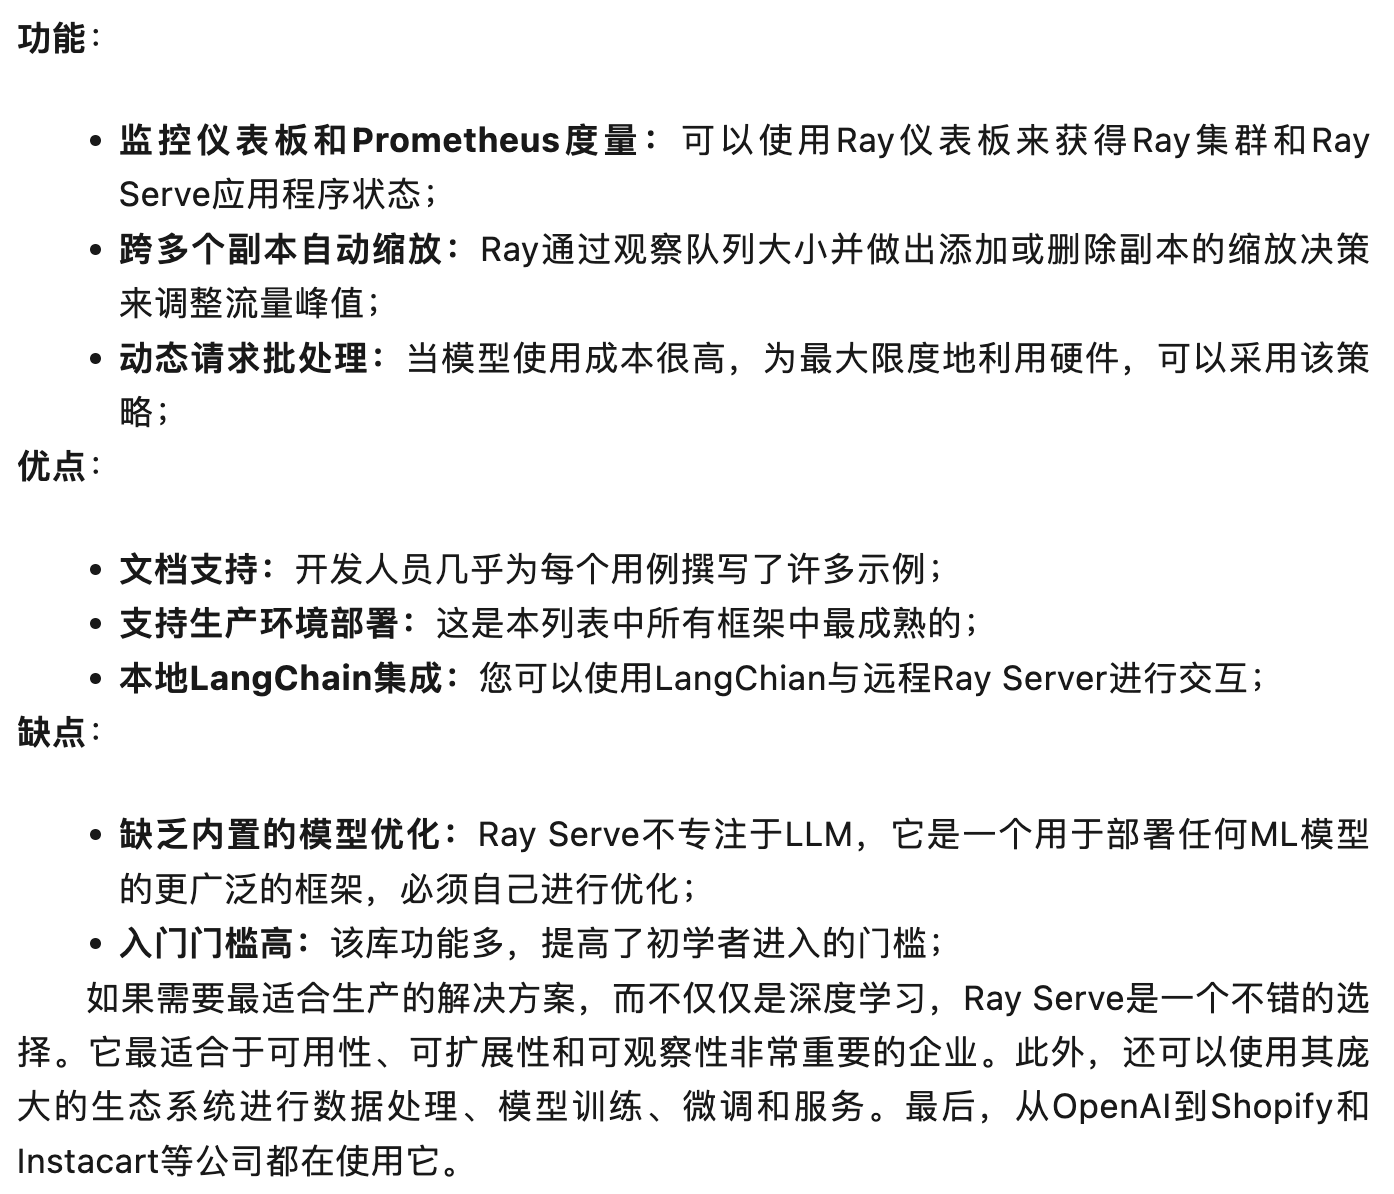